# Sampling user groups from the LFM1b dataset

**BEFORE YOU RUN THE NOTEBOOK**:

Make sure you place the unzipped [LFM1b dataset](https://drive.jku.at/ssf/s/readFile/share/1056/266403063659030189/publicLink/LFM-1b.zip) (published in [this paper](http://www.cp.jku.at/people/schedl/Research/Publications/pdf/schedl_ism_mam_2017.pdf)) in the `./data` folder

This notebook does:
- replicate the sampling performed in [this paper about unfairness in music recommendations](https://link.springer.com/chapter/10.1007%2F978-3-030-45442-5_5) --> "extreme" strategy
- replicate the sample strategy used in [this paper about unfairness in music recommendations](https://arxiv.org/abs/1907.13286) --> "percentile" strategy
- compare these two ways of creating user samples

In [47]:
import time

import pandas as pd
import numpy as np
import os
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

In [48]:
out_folder = "./data/user_groups"

if not os.path.exists(out_folder):
    os.mkdir(out_folder)

In [49]:
extreme_relevant_user_ids = set()
percentile_relevant_user_ids = set()

## Load LFM1b data

In [50]:
users_additional = pd.read_csv("data/LFM-1b/LFM-1b_users_additional.txt", sep="\t")

In [51]:
users_additional
sorted_user_add = users_additional.sort_values(by="mainstreaminess_global")

## Sample according to "extreme" strategy

In [52]:
sorted_user_add["mainstreaminess_global"] == sorted_user_add["mainstreaminess_global"].median()

69165     False
25230     False
105083    False
116054    False
110784    False
          ...  
18190     False
35278     False
13605     False
32889     False
31726     False
Name: mainstreaminess_global, Length: 120322, dtype: bool

In [53]:
low_main_users =  sorted_user_add.iloc[0:1000,]

n = sorted_user_add.shape[0]
lower = int((n/2) - 500)
higher = int((n/2) + 500)

medium_main_users = sorted_user_add.iloc[lower:higher,]
high_main_users =  sorted_user_add.iloc[-1000:,]


In [54]:
low_main_users[["user-id", "mainstreaminess_global"]].to_csv(f"{out_folder}/extreme_low_main_users.csv")
medium_main_users[["user-id", "mainstreaminess_global"]].to_csv(f"{out_folder}/extreme_medium_main_users.csv")
high_main_users[["user-id", "mainstreaminess_global"]].to_csv(f"{out_folder}/extreme_high_main_users.csv")

extreme_relevant_user_ids = extreme_relevant_user_ids.union(low_main_users["user-id"])
extreme_relevant_user_ids = extreme_relevant_user_ids.union(medium_main_users["user-id"])
extreme_relevant_user_ids = extreme_relevant_user_ids.union(high_main_users["user-id"])

## Sample according to "percentile" strategy

In [55]:
twenty_percentile = users_additional["mainstreaminess_global"].quantile(0.2)
eighty_percentile = users_additional["mainstreaminess_global"].quantile(0.8)

low_percentile_main_users = users_additional[users_additional["mainstreaminess_global"] <= twenty_percentile].sample(1000)
medium_percentile_main_users = users_additional[np.logical_and(users_additional["mainstreaminess_global"] > twenty_percentile, users_additional["mainstreaminess_global"] < eighty_percentile)].sample(1000)
high_percentile_main_users = users_additional[users_additional["mainstreaminess_global"] >= eighty_percentile].sample(1000)

In [56]:
low_percentile_main_users[["user-id", "mainstreaminess_global"]].to_csv(f"{out_folder}/percentile_low_main_users.csv")
medium_percentile_main_users[["user-id", "mainstreaminess_global"]].to_csv(f"{out_folder}/percentile_medium_main_users.csv")
high_percentile_main_users[["user-id", "mainstreaminess_global"]].to_csv(f"{out_folder}/percentile_high_main_users.csv")

percentile_relevant_user_ids = percentile_relevant_user_ids.union(low_percentile_main_users["user-id"])
percentile_relevant_user_ids = percentile_relevant_user_ids.union(medium_percentile_main_users["user-id"])
percentile_relevant_user_ids = percentile_relevant_user_ids.union(high_percentile_main_users["user-id"])

In [57]:
## Create user events files
cols = ['user', 'artist', 'album', 'track', 'timestamp']
full_le = dd.read_csv('data/LFM-1b/LFM-1b_LEs.txt', sep="\t", names = cols)


In [58]:
extreme_user_le_filtering = full_le.loc[full_le["user"].isin(extreme_relevant_user_ids)]
with ProgressBar():
    extreme_relevant_le = extreme_user_le_filtering.compute()

[########################################] | 100% Completed |  2min 34.5s


In [59]:
percentile_user_le_filtering = full_le.loc[full_le["user"].isin(percentile_relevant_user_ids)]
with ProgressBar():
    percentile_relevant_le = percentile_user_le_filtering.compute()

[########################################] | 100% Completed |  2min 41.3s


Saves two files ~ 3GB in total size

In [60]:
if not os.path.exists(f"{out_folder}/percentile_user_events.csv"):
    percentile_relevant_le.to_csv(f"{out_folder}/percentile_user_events.csv")

In [61]:
if not os.path.exists(f"{out_folder}/extreme_user_events.csv"):
    extreme_relevant_le.to_csv(f"{out_folder}/extreme_user_events.csv")

## Recreate analysis

This is mainly a copy of the `LFM_Fairness.ipynb` from the original paper

In [62]:
import random as rd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from scipy import stats
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

In [63]:
# constants and initialization
item_threshold = 1 # 1 means no filtering
my_seed = 0
rd.seed(my_seed)
np.random.seed(my_seed)
predict_col = 'artist'
top_fraction = 0.2

## CHANGE THIS ACCORDINGLY ##
mode = "percentile"
user_events_file = f'./data/user_groups/{mode}_user_events.csv'
low_user_file = f'data/user_groups/{mode}_low_main_users.csv'
medium_user_file = f'data/user_groups/{mode}_medium_main_users.csv'
high_user_file = f'data/user_groups/{mode}_high_main_users.csv'

In [64]:
if f'{mode}_relevant_le' in locals():
    df_events = locals()[f"{mode}_relevant_le"]
else:
    # read user events
    cols = ['user', 'artist', 'album', 'track', 'timestamp']
    with ProgressBar():
        df_events = dd.read_csv(user_events_file, names=cols).compute()
    print('No. of user events: ' + str(len(df_events)))

In [65]:
# create user-item matrix
df_events = df_events.groupby(['user', predict_col]).size().reset_index(name='count')
print('No. user-item interactions: ' + str(len(df_events)))

No. user-item interactions: 1787192


In [66]:
df_events.head()

,user,artist,count
0,1031170,16,4
1,1031170,32,1
2,1031170,46,3
3,1031170,55,2
4,1031170,79,2


In [67]:
df_events = df_events[df_events['count'] >= item_threshold]
print('No. filtered user events: ' + str(len(df_events)))
print('No. filtered items: ' + str(len(df_events[predict_col].unique())))

No. filtered user events: 1787192
No. filtered items: 318116


In [68]:
# get user distribution
user_dist = df_events['user'].value_counts()
num_users = len(user_dist)
print('Mean artists per user: ' + str(user_dist.mean()))
print('Min artists per user: ' + str(user_dist.min()))
print('Max artists per user: ' + str(user_dist.max()))

Mean artists per user: 595.7306666666667
Min artists per user: 3
Max artists per user: 11959


In [69]:
# get item distribution
item_dist = df_events[predict_col].value_counts()
num_items = len(item_dist)
print('No. items: ' + str(num_items))

No. items: 318116


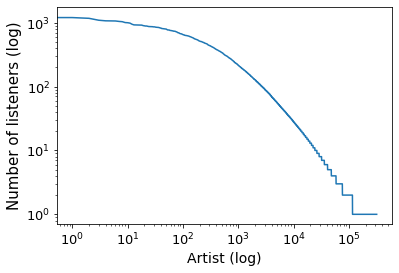

In [70]:
# plot item distribution
plt.figure()
plt.plot(item_dist.values)
plt.xlabel('Artist (log)', fontsize='14')
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
plt.ylabel('Number of listeners (log)', fontsize='15')
plt.xscale('log')
plt.yscale('log')

In [71]:
# get top items
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. top items: ' + str(len(top_item_dist)))

No. top items: 63623


In [72]:
# read users
low_users = pd.read_csv(low_user_file).set_index('user-id')
medium_users = pd.read_csv(medium_user_file).set_index('user-id')
high_users = pd.read_csv(high_user_file).set_index('user-id')
no_users = len(low_users) + len(medium_users) + len(high_users)
print('No. of users: ' + str(no_users))

No. of users: 3000


In [73]:
# get pop fractions
pop_count = [] # number of top items per user
user_hist = [] # user history sizes
pop_fraq = [] # relative number of top items per user
pop_item_fraq = [] # average popularity of items in user profiles
low_profile_size = 0
low_gap = 0
medium_profile_size = 0
medium_gap = 0
high_profile_size = 0
high_gap = 0
low_count = 0
med_count = 0
high_count = 0
for u, df in df_events.groupby('user'):
    no_user_items = len(set(df[predict_col])) # profile size
    no_user_pop_items = len(set(df[predict_col]) & set(top_item_dist.index)) # top items in profile
    pop_count.append(no_user_pop_items)
    user_hist.append(no_user_items)
    pop_fraq.append(no_user_pop_items / no_user_items)
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_item_fraq = sum(item_dist[df[predict_col]] / no_users) / no_user_items
    pop_item_fraq.append(user_pop_item_fraq)
    if u in low_users.index: # get user group-specific values
        low_profile_size += no_user_items
        low_gap += user_pop_item_fraq
        low_count += 1
    elif u in medium_users.index:
        medium_profile_size += no_user_items
        medium_gap += user_pop_item_fraq
        med_count += 1
    else:
        high_profile_size += no_user_items
        high_gap += user_pop_item_fraq
        high_count += 1
low_profile_size /= len(low_users)
medium_profile_size /= len(medium_users)
high_profile_size /= len(high_users)
low_gap /= len(low_users)
medium_gap /= len(medium_users)
high_gap /= len(high_users)
print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))

Low count (for check): 1000
Med count (for check): 1000
High count (for check): 1000


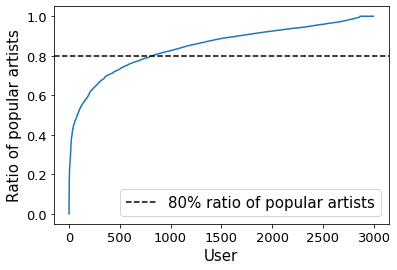

In [74]:
plt.figure()
plt.plot(sorted(pop_fraq))
plt.xlabel('User', fontsize='15')
plt.xticks(fontsize='13')
plt.ylabel('Ratio of popular artists', fontsize='15')
plt.yticks(fontsize='13')
plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular artists')
plt.legend(fontsize='15')


R-value: 0.9795958700763274


(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 <a list of 7 Text yticklabel objects>)

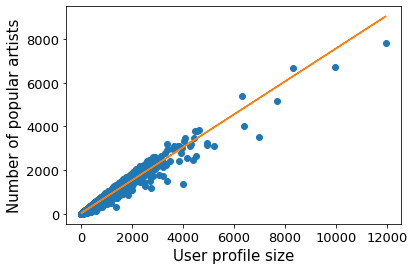

In [75]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_count)
print('R-value: ' + str(r_value))
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_count, 'o', user_hist, line)
plt.xlabel('User profile size', fontsize='15')
plt.xticks(fontsize='13')
plt.ylabel('Number of popular artists', fontsize='15')
plt.yticks(fontsize='13')


R-value: -0.19649434107129496
SpearmanrResult(correlation=-0.1035503663315709, pvalue=1.3111119513759904e-08)


(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25]),
 <a list of 7 Text yticklabel objects>)

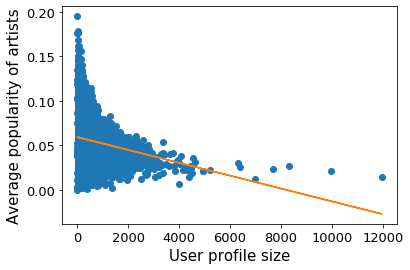

In [76]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_item_fraq)
print('R-value: ' + str(r_value))
print(stats.spearmanr(user_hist, pop_item_fraq))
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_item_fraq, 'o', user_hist, line)
plt.xlabel('User profile size', fontsize='15')
plt.ylabel('Average popularity of artists', fontsize='15')
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')

In [77]:
print('Average LowMS profile size: ' + str(low_profile_size))
print('Average MedMS profile size: ' + str(medium_profile_size))
print('Average HighMS profile size: ' + str(high_profile_size))

Average LowMS profile size: 153.999
Average MedMS profile size: 434.022
Average HighMS profile size: 1199.171


### Recommendations using Surprise package

In [78]:
scaled_df_events = pd.DataFrame()
for user_id, group in df_events.groupby('user'):
    min_rating = group['count'].min()
    max_rating = group['count'].max()
    scaler = MinMaxScaler(feature_range=(1, 1000))
    scaled_ratings = scaler.fit_transform(group['count'].values.reshape(-1, 1).astype(float))
    new_rows = group.copy()
    new_rows['count'] = scaled_ratings
    scaled_df_events = scaled_df_events.append(new_rows)

scaled_df_events.head()
#scaled_df_events = scaled_df_events.set_index('user') # needed for new python/surprise version

,user,artist,count
0,1031170,16,5.1625
1,1031170,32,1.0000
2,1031170,46,3.7750
3,1031170,55,2.3875
4,1031170,79,2.3875


In [79]:
df_events = scaled_df_events
print('Min rating: ' + str(df_events['count'].min()))
print('Max rating: ' + str(df_events['count'].max()))

Min rating: 1.0
Max rating: 1000.0000000000002


In [80]:
reader = Reader(rating_scale=(df_events['count'].min(), df_events['count'].max()))
df_events.head()

,user,artist,count
0,1031170,16,5.1625
1,1031170,32,1.0000
2,1031170,46,3.7750
3,1031170,55,2.3875
4,1031170,79,2.3875


In [81]:
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_events, reader)

In [82]:
trainset, testset = train_test_split(data, test_size = 0.2, random_state = my_seed)

In [83]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [84]:
def get_top_n_random(testset, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for i in range(0, 10):
                top_n[uid].append((rd.choice(item_dist.index), i))
    return top_n


In [85]:
def get_top_n_mp(testset, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for iid, count in item_dist[:n].items():
                top_n[uid].append((iid, count))
    return top_n

In [86]:
def get_mae_of_groups(predictions):
    print('All: ')
    accuracy.mae(predictions)
    low_predictions = []
    med_predictions = []
    high_predictions = []
    for uid, iid, true_r, est, details in predictions:
        prediction = [(uid, iid, true_r, est, details)]
        if uid in low_users.index:
            low_predictions.append(accuracy.mae(prediction, verbose=False))
        elif uid in medium_users.index:
            med_predictions.append(accuracy.mae(prediction, verbose=False))
        else:
            high_predictions.append(accuracy.mae(prediction, verbose=False))
    print('LowMS: ' + str(np.mean(low_predictions)))
    print('MedMS: ' + str(np.mean(med_predictions)))
    print('HighMS: ' + str(np.mean(high_predictions)))
    print(stats.ttest_ind(low_predictions, high_predictions))

In [87]:
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist)
df_item_dist.columns = ['count']
df_item_dist['count'] /= no_users

In [88]:
sim_users = {'name': 'cosine', 'user_based': True}  # compute cosine similarities between users
algos = [] # Random and MostPopular is calculated by default
algos.append(None)#Random())
algos.append(None)#MostPopular())
algos.append(BaselineOnly())
algos.append(KNNBasic(sim_options = sim_users, k=40))
algos.append(KNNWithMeans(sim_options = sim_users, k=40))
algos.append(NMF(n_factors = 15))
algo_names = ['Random',
              'MostPopular',
              'UserItemAvg',
              'UserKNN',
              'UserKNNAvg',
              'NMF']

i = 0
low_rec_gap_list = [] # one entry per algorithmus
medium_rec_gap_list = []
high_rec_gap_list = []
for i in range(0, len(algo_names)):
    df_item_dist[algo_names[i]] = 0
    low_rec_gap = 0
    medium_rec_gap = 0
    high_rec_gap = 0

    # get accuracy for personalized approaches
    if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':
        algos[i].fit(trainset)
        predictions = algos[i].test(testset)
        print(algo_names[i])
        get_mae_of_groups(predictions)

    # get top-n items and calculate gaps for all algorithms
    if algo_names[i] == 'Random':
        top_n = get_top_n_random(testset, n=10)
    elif algo_names[i] == 'MostPopular':
        top_n = get_top_n_mp(testset, n=10)
    else:
        top_n = get_top_n(predictions, n=10)
    low_count = 0
    med_count = 0
    high_count = 0
    for uid, user_ratings in top_n.items():
        iid_list = []
        for (iid, _) in user_ratings:
            df_item_dist.loc[iid, algo_names[i]] += 1
            iid_list.append(iid)
        gap = sum(item_dist[iid_list] / no_users) / len(iid_list)
        if uid in low_users.index:
            low_rec_gap += gap
            low_count += 1
        elif uid in medium_users.index:
            medium_rec_gap += gap
            med_count += 1
        elif uid in high_users.index:
            high_rec_gap += gap
            high_count += 1
    low_rec_gap_list.append(low_rec_gap / low_count)
    medium_rec_gap_list.append(medium_rec_gap / med_count)
    high_rec_gap_list.append(high_rec_gap / high_count)
    i += 1 # next algorithm

<>:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\floba\AppData\Local\Temp/ipykernel_21848/3091362969.py:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':
C:\Users\floba\AppData\Local\Temp/ipykernel_21848/3091362969.py:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':


Estimating biases using als...
UserItemAvg
All: 
MAE:  36.7494
LowMS: 73.58142523932155
MedMS: 45.34268957666566
HighMS: 28.87160808913773
Ttest_indResult(statistic=104.81052352641878, pvalue=0.0)
Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNN
All: 
MAE:  47.7570
LowMS: 74.34833030996796
MedMS: 52.87504068054234
HighMS: 42.46366552414317
Ttest_indResult(statistic=69.8573648640003, pvalue=0.0)
Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNNAvg
All: 
MAE:  40.7324
LowMS: 76.08155068063606
MedMS: 48.87153436634032
HighMS: 33.210993668023846
Ttest_indResult(statistic=98.06280401747284, pvalue=0.0)
NMF
All: 
MAE:  33.0791
LowMS: 68.77307436320632
MedMS: 41.38446726294864
HighMS: 25.452829184393373
Ttest_indResult(statistic=88.8367334634798, pvalue=0.0)


<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\floba\AppData\Local\Temp/ipykernel_21848/3473304281.py:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':
C:\Users\floba\AppData\Local\Temp/ipykernel_21848/3473304281.py:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':
c:\repos\tuw_expdesignws2021\.venv\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
c:\repos\tuw_expdesignws2021\.venv\lib\site

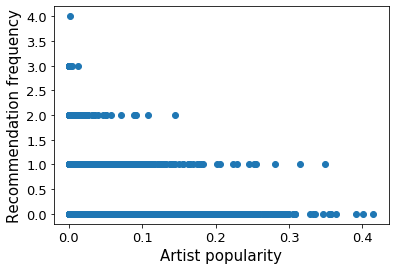

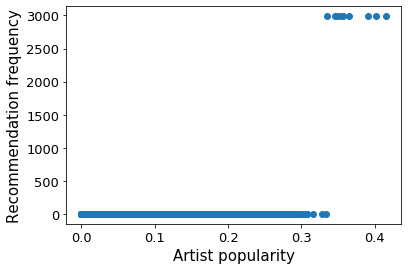

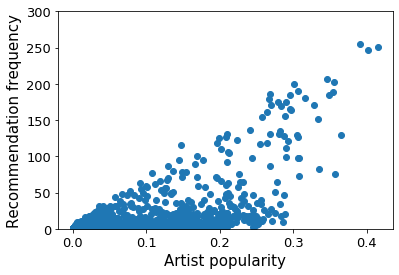

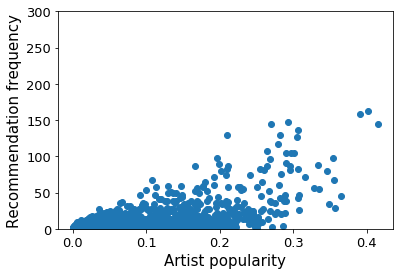

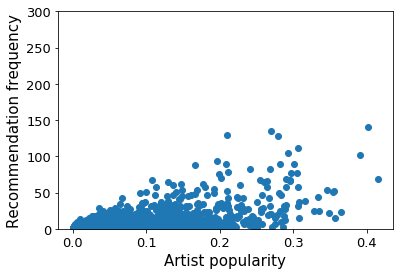

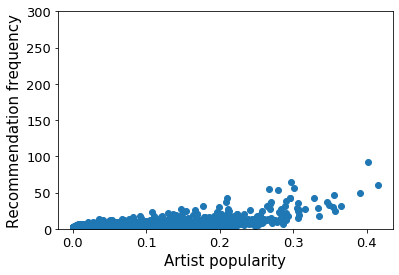

In [89]:
for i in range(0, len(algo_names)):
    plt.figure()
    x = df_item_dist['count']
    y = df_item_dist[algo_names[i]]
    #slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    #line = slope * np.array(x) + intercept
    #print(r_value)
    if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':
        plt.gca().set_ylim(0, 300)
    plt.plot(x, y, 'o')#, x, line)
    plt.xlabel('Artist popularity', fontsize='15')
    plt.ylabel('Recommendation frequency', fontsize='15')
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')

In [90]:
low_gap_vals = []
medium_gap_vals = []
high_gap_vals = []

for i in range(0, len(algos)):
    low_gap_vals.append((low_rec_gap_list[i] - low_gap) / low_gap * 100)
    medium_gap_vals.append((medium_rec_gap_list[i] - medium_gap) / medium_gap * 100)
    high_gap_vals.append((high_rec_gap_list[i] - high_gap) / high_gap * 100)

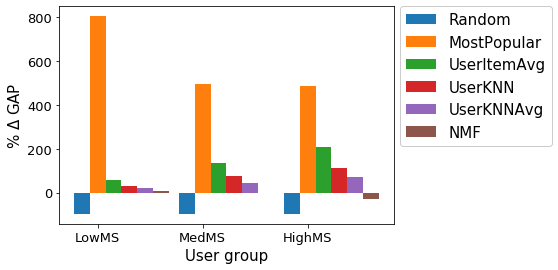

In [91]:
# set width of bar
barWidth = 0.15

# set height of bar
bars1 = [low_gap_vals[0], medium_gap_vals[0], high_gap_vals[0]]
bars2 = [low_gap_vals[1], medium_gap_vals[1], high_gap_vals[1]]
bars3 = [low_gap_vals[2], medium_gap_vals[2], high_gap_vals[2]]
bars4 = [low_gap_vals[3], medium_gap_vals[3], high_gap_vals[3]]
bars5 = [low_gap_vals[4], medium_gap_vals[4], high_gap_vals[4]]
bars6 = [low_gap_vals[5], medium_gap_vals[5], high_gap_vals[5]]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

# Make the plot
plt.bar(r1, bars1, width=barWidth, label='Random')
plt.bar(r2, bars2, width=barWidth, label='MostPopular')
plt.bar(r3, bars3, width=barWidth, label='UserItemAvg')
plt.bar(r4, bars4, width=barWidth, label='UserKNN')
plt.bar(r5, bars5, width=barWidth, label='UserKNNAvg')
plt.bar(r6, bars6, width=barWidth, label='NMF')

# Add xticks on the middle of the group bars + show legend
plt.xlabel('User group', fontsize='15')
plt.ylabel('% $\Delta$ GAP', fontsize='15')
plt.xticks([r + barWidth for r in range(len(bars1))], ['LowMS', 'MedMS', 'HighMS'], fontsize='13')
plt.yticks(fontsize='13')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='15')
#plt.savefig('data/ECIR/gap_analysis.png', dpi=300, bbox_inches='tight')